# Uses ROMS Surface variables for Spectral Analysis
#### Computes SST'xHFX' and regression coefficient

In [11]:
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import gc
import xarray as xr
import pandas as pd
import xrft as xrft
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter as gauss
# from scipy.integrate import trapezoid as trapz
from pyspec import spectrum as spec
from matplotlib.colors import LogNorm
import warnings
import scipy.signal as sig
import scipy.stats as stats
import sys
import seaborn as sns
sys.path.append("/homes/metogra/iufarias/FeedbackSubmeso/useful/")
import romspickle


from dask.diagnostics import ProgressBar


import scipy.integrate as integ
warnings.filterwarnings("ignore")

In [12]:

plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 22})

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Lucida Grande']

In [13]:
def spec_ogive(spec,kr):
    
    Ogive_Kr=np.array(kr)
    # Middle Value Wavenumber position for plot
    Ogive_Krx=(Ogive_Kr[:-1]+Ogive_Kr[1:])/2
    # dK=np.diff(Ogive_Kr)[0]
    
    #Flipped Integration in wavenumber and then flipped again
    Ogive_inv=integ.cumtrapz(y=spec[::-1],x=Ogive_Kr[::-1]);
    Ogive_Spec=-Ogive_inv[::-1];


    return Ogive_Krx,Ogive_Spec

def ogive(deltaf,G):
   '''
   ogive(deltaf,G): use very simple integration to calculate the ogive 
   from a spectrum G with data sampled at frequency deltaf.
   2017-01-10T09:40:31 going back to a single frequency for Os and Gs
   '''
# --------------------------------------------------------------------
# 2016-10-08T09:47:12 re-created with numpy
# --------------------------------------------------------------------
   M1 = len(G)
   Og = np.zeros(M1,float)
   Og[0:M1] = np.cumsum(np.flipud(G[0:M1]))
   Og *= deltaf
   Og = np.flipud(Og)
   return Og



In [14]:

path='/data/pacific/lrenault/SASI/CROCO/FULL/'
listm=glob(path+'surf*.nc');listm.sort()
# varf=xr.open_dataset(listm[-9:][xmon])
varf=xr.open_mfdataset(listm[1:],data_vars='minimal')

path='/data/pacific/lrenault/SASI/CROCO/SMTH/'
listt=glob(path+'surf*SASI_6h_his_20*_*.nc');listt.sort()
listt.append('/data/pacific/lrenault/SASI/CROCO/SMTH/surf_SASI_6h_his_2012-07.nc')
#vart=xr.open_dataset(listt[xmon])
vart=xr.open_mfdataset(listt[1:],data_vars='minimal')

In [15]:
dxx=0.5
dyy=dxx

In [16]:
import datetime

# t_ind=pd.DatetimeIndex(varf.time_counter.compute())
t_ind=varf.time_counter.groupby("time_counter.dayofyear").mean()
mon_ind=t_ind.dt.month
mes=np.array([12,1,2,3,4,5,6,7])
mes_str=['Dec/11','Jan/12','Feb/12','Mar/12','Apr/12','May/12','Jun/12','Jul/12']

## Spectral Analysis

#### Test - SST and Heatflux

In [17]:
chunks_new={'dayofyear':40}

In [18]:
%%time


tf=varf.temp.groupby("time_counter.dayofyear").mean()
tf=tf.chunk(chunks=chunks_new);
tf=tf[:,120:-120,120:800].compute();

tt=vart.temp.groupby("time_counter.dayofyear").mean()
tt=tt.chunk(chunks=chunks_new);
tt=tt[:,120:-120,120:800].compute();


hf=-varf.shflx.groupby("time_counter.dayofyear").mean()
hf=hf.chunk(chunks=chunks_new);
hf=hf[:,120:-120,120:800].compute();

ht=-vart.shflx.groupby("time_counter.dayofyear").mean()
ht=ht.chunk(chunks=chunks_new);
ht=ht[:,120:-120,120:800].compute();


CPU times: user 1min 7s, sys: 20.6 s, total: 1min 28s
Wall time: 8.87 s


In [19]:
nf=2
wdws='hann' #'flattop','hann'
wdw_cor=True
scl='density'




In [20]:


with ProgressBar():
    TTf=xrft.isotropic_power_spectrum(tf.drop(['nav_lat_rho','nav_lon_rho','dayofyear']),
                                      dim=['y_rho','x_rho'],
                              nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor)

    TTt=xrft.isotropic_power_spectrum(tt.drop(['nav_lat_rho','nav_lon_rho','dayofyear']),
                                      dim=['y_rho','x_rho'],
                              nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor)

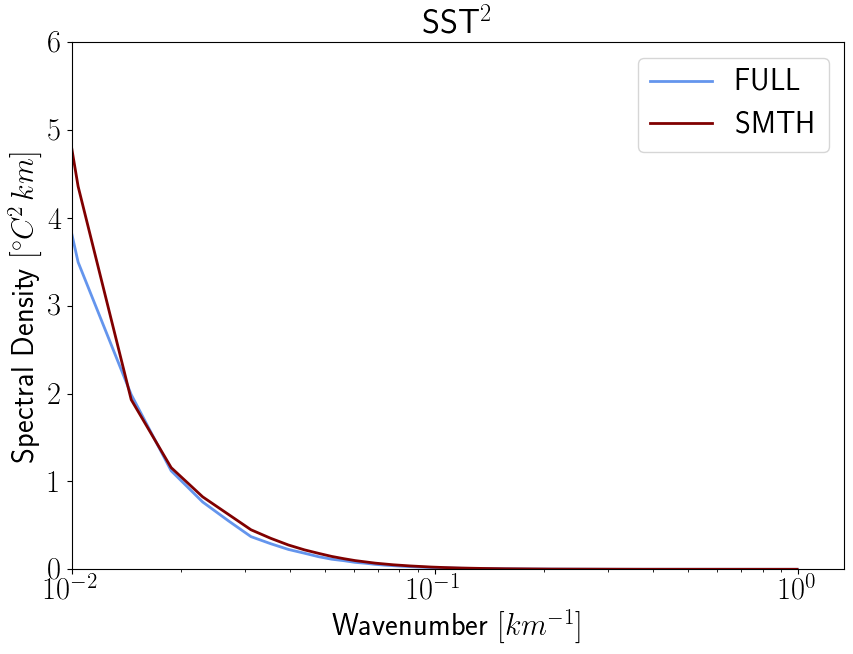

In [21]:
plt.figure(figsize=(9,7))


plt.plot(TTf.freq_r/dxx,TTf.mean(axis=0)/dxx,label='FULL',linewidth=2,color='cornflowerblue')
plt.plot(TTt.freq_r/dxx,TTt.mean(axis=0)/dxx,label='SMTH',linewidth=2,color='maroon')


plt.legend()

# plt.yscale('log')
plt.xscale('log')


# plt.grid()
# plt.title('Full Period {0}'.format(varr))
# plt.xlim(-5,-3)
# plt.xticks(np.array([-2,-1]),[r'10$^{-2}$',r'10$^{-1}$'])
# plt.yticks(np.array([-3,-1,1,3,6]),[r'10$^{-3}$',r'10$^{-1}$',r'10$^{1}$',r'10$^{3}$',r'10$^{6}$'])


plt.title(r'SST$^{2}$',fontsize=25)
plt.xlabel(r'Wavenumber  $[km^{-1}]$',fontweight='bold')
plt.ylabel(r'Spectral Density $[^{\circ}C^{2}\,km]\,$',fontweight='bold')

plt.xlim(1/100,0)
plt.ylim(0,6)
plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/CROCO_surface/Total_avg_SST.png')

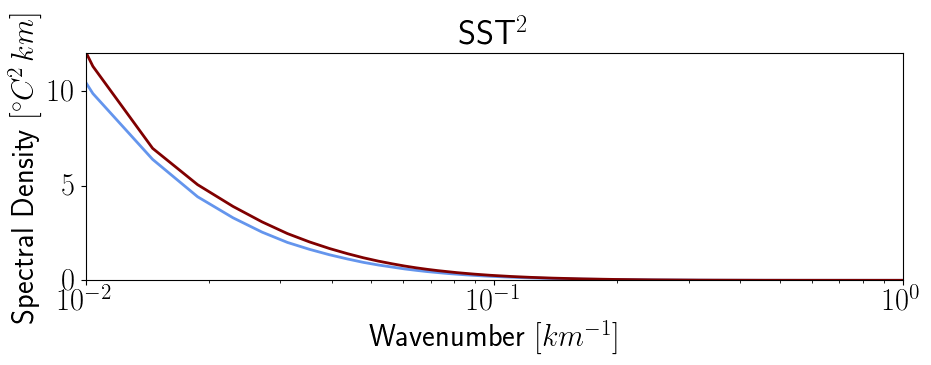

In [22]:
TOf=ogive(TTf.freq_r/dxx,TTf.mean(axis=0)/dxx)
Kx=TTf.freq_r/dxx
TOt=ogive(TTt.freq_r/dxx,TTt.mean(axis=0)/dxx)

fig,ax = plt.subplots(figsize=(10,4))
ax.plot(Kx,TOf,label='FULL',linewidth=2,color='cornflowerblue')
ax.plot(Kx,TOt,label='SMTH',linewidth=2,color='maroon')
ax.set_xticks(np.array([-2,-1]))
ax.set_xticklabels([r'10$^{-2}$',r'10$^{-1}$'])
ax.set_title(r'SST$^{2}$',fontsize=25)
ax.set_xlabel(r'Wavenumber $ [km^{-1}]$',fontweight='bold')
ax.set_ylabel(r'Spectral Density $[^{\circ}C^{2}\,km]\,$',color="k")

# ax.set_ylabel(r'$ $}',color="k",fontsize=15,fontweight='bold')
ax.set_xscale('log')

ax.set_xlim(1e-2,1)
ax.set_ylim(0,12)
plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/CROCO_surface/ogives/Ogive_avg_SST.png')

# Calculating VBP

###### Not a reliable analysis, since there is a w BC for ROMS. Use 100m integrated version instead.

In [23]:
sf=varf.salt.groupby("time_counter.dayofyear").mean()
sf=sf.chunk(chunks=chunks_new);
sf=sf[:,120:-120,120:800].compute();

st=vart.salt.groupby("time_counter.dayofyear").mean()
st=st.chunk(chunks=chunks_new);
st=st[:,120:-120,120:800].compute();

In [24]:
%%time
wf=varf.w.groupby("time_counter.dayofyear").mean()
wf=wf.chunk(chunks=chunks_new);
wf=wf[:,120:-120,120:800].compute();

wt=vart.w.groupby("time_counter.dayofyear").mean()
wt=wt.chunk(chunks=chunks_new);
wt=wt[:,120:-120,120:800].compute();



CPU times: user 30.8 s, sys: 9.8 s, total: 40.6 s
Wall time: 1min 30s


In [25]:
import xroms 

rhof=xroms.potential_density(tf,sf)
rhot=xroms.potential_density(tt,st)

In [26]:
bf=xroms.buoyancy(rhof)#[:,1:-1,:]
bt=xroms.buoyancy(rhot)#[:,1:-1,:]

In [27]:
%%time
with ProgressBar():
    Bf=xrft.isotropic_power_spectrum(bf.drop(['nav_lat_rho','nav_lon_rho','dayofyear']),
                                      dim=['y_rho','x_rho'],
                              nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor)

    Bt=xrft.isotropic_power_spectrum(bt.drop(['nav_lat_rho','nav_lon_rho','dayofyear']),
                                      dim=['y_rho','x_rho'],
                              nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor)

    Wf=xrft.isotropic_power_spectrum(wf.drop(['nav_lat_rho','nav_lon_rho','dayofyear']),
                                      dim=['y_rho','x_rho'],
                              nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor)

    Wt=xrft.isotropic_power_spectrum(wt.drop(['nav_lat_rho','nav_lon_rho','dayofyear']),
                                      dim=['y_rho','x_rho'],
                              nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor)

CPU times: user 13min 23s, sys: 40min 16s, total: 53min 40s
Wall time: 1min 12s


In [28]:
%%time
with ProgressBar():
    VBPf=xrft.isotropic_cross_spectrum(wf.drop(['nav_lat_rho','nav_lon_rho','dayofyear']),bf.drop(['nav_lat_rho','nav_lon_rho','dayofyear']),
                                      dim=['y_rho','x_rho'],nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor).real
    
    VBPt=xrft.isotropic_cross_spectrum(wt.drop(['nav_lat_rho','nav_lon_rho','dayofyear']),bt.drop(['nav_lat_rho','nav_lon_rho','dayofyear']),
                                      dim=['y_rho','x_rho'],nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor).real

CPU times: user 13min 7s, sys: 40min 3s, total: 53min 10s
Wall time: 57.2 s


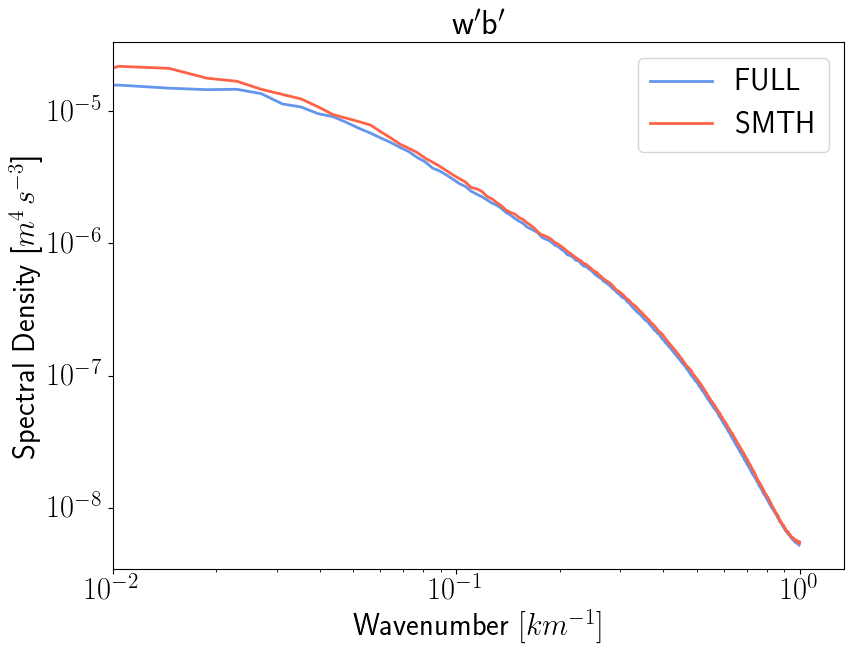

In [29]:

plt.figure(figsize=(9,7))


plt.plot(VBPf.freq_r/dxx,VBPf.mean(axis=0)/dxx*1e3,label='FULL',linewidth=2,color='cornflowerblue') #correcting for m in kr
plt.plot(VBPt.freq_r/dxx,VBPt.mean(axis=0)/dxx*1e3,label='SMTH',linewidth=2,color='tomato')

plt.legend()

plt.yscale('symlog',linthresh=1e-11)
plt.xscale('log')

plt.title('w$^{\prime}$b$^{\prime}$',fontsize=25,fontweight='bold')
plt.ylabel(r'Spectral Density [$m^4\,s^{-3}$]',fontweight='bold')
plt.xlabel(r'Wavenumber  $[km^{-1}]$',fontweight='bold')


plt.xlim(1/100,0)
# plt.ylim(1e-8,1e-1)
# plt.grid()

plt.tight_layout()


plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/CROCO_surface/total_avg/Total_avg_SURFACE_VBP.png')

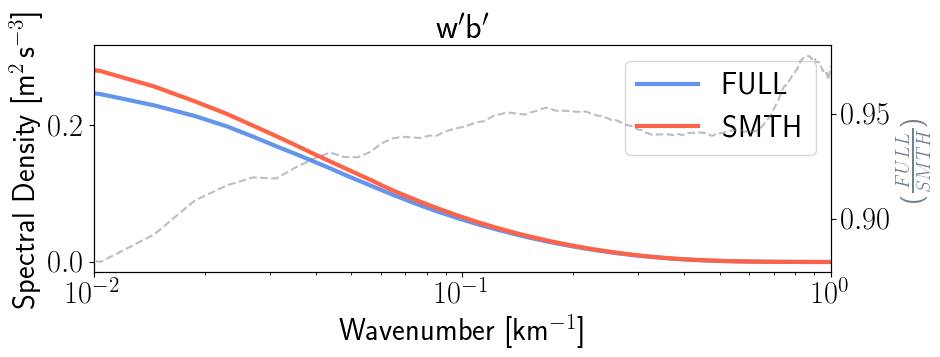

In [74]:
# 'Ogive graph'


KAf=ogive(VBPf.freq_r/dxx*1e3,np.nanmean(VBPf,axis=0)/dxx*1e3) #in metersss
Kx=VBPf.freq_r/dxx #in Kilometers
KAt=ogive(VBPt.freq_r/dxx*1e3,np.nanmean(VBPt,axis=0)/dxx*1e3)#in metersss

# Kx,KAf=spec_ogive(spec=np.nanmean(VBPf,axis=0)/dxx*1e3,kr=VBPf.freq_r/dxx)
# _,KAt=spec_ogive(spec=np.nanmean(VBPt,axis=0)/dxx*1e3,kr=VBPt.freq_r/dxx)

fig,ax = plt.subplots(figsize=(10,4))
ax.plot(Kx,KAf,label='FULL',linewidth=3,color='cornflowerblue')
ax.plot(Kx,KAt,label='SMTH',linewidth=3,color='tomato')
ax.set_title('w$^{\prime}$b$^{\prime}$',fontsize=25,fontweight='bold')

ax.set_xscale('log')

ax.set_xlabel(r'Wavenumber [km$^{-1}$]',fontweight='bold')
ax.set_ylabel(r'Spectral Density [m$^2\,$s$^{-3}$]',fontweight='bold')
ax.set_xlim(1e-2,1)
# ax.set_ylim(-1e-11,4e-11)


ax.legend()

ax2=ax.twinx()
ax2.plot((Kx),((KAf)/(KAt)),alpha=0.5,linestyle='dashed',color='slategrey')
ax2.set_ylabel(r'($\frac{FULL}{SMTH}$)',fontsize=20,color='slategrey')

ax2.set_xscale('log')
plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/CROCO_surface/ogives/ogive_SURFACE_VBP.png')
# 

In [31]:
N2r=(5.2*10**-3)**2

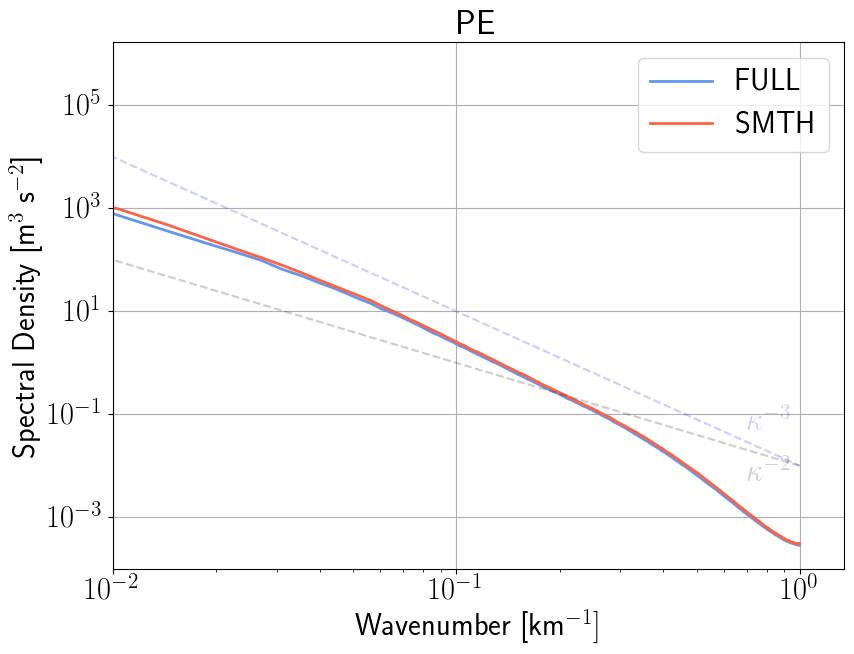

In [32]:
plt.figure(figsize=(9,7))


plt.plot(Bf.freq_r/dxx,(1/(2*N2r))*Bf.mean(axis=0)/dxx*1e3,label='FULL',linewidth=2,color='cornflowerblue') #correcting for m in kr
plt.plot(Bt.freq_r/dxx,(1/(2*N2r))*Bt.mean(axis=0)/dxx*1e3,label='SMTH',linewidth=2,color='tomato')



k2 = np.array([Bf.freq_r[0],Bf.freq_r[-1]])/dxx
E2 = ((1/k2)**2)*(1e-2)

k3 = np.array([Bf.freq_r[0],Bf.freq_r[-1]])/dxx
E3 = ((1/k3)**3)*(1e-2)




plt.plot(k2,E2,'k--',alpha=0.2)
plt.text(0.7,0.5e-2,r'$\kappa^{-2}$',weight='normal',alpha=0.2)

plt.plot(k3,E3,'b--',alpha=0.2)
plt.text(0.7,5e-2,r'$\kappa^{-3}$',weight='normal',color='b',alpha=0.2)



plt.legend()

plt.yscale('log')
plt.xscale('log')

# plt.title(r'$\frac{1}{2}\,\frac{b^{2}}{N_r^{2}}$',fontweight='bold')
plt.title(r'PE',fontweight='bold',fontsize=25)


plt.ylabel(r'Spectral Density [m$^3$ s$^{-2}$]',fontweight='bold')
plt.xlabel(r'Wavenumber  [km$^{-1}]$',fontweight='bold')


plt.xlim(1/100,0)
# plt.ylim(1e-8,1e-1)
plt.grid()

plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/CROCO_surface/total_avg/Total_avg_surface_PE.png')

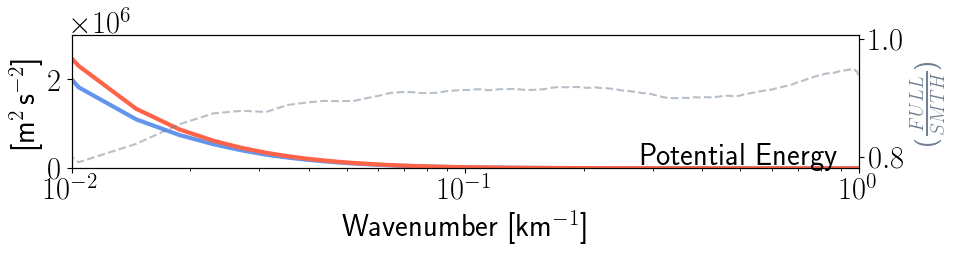

In [76]:
# Kx,Kbf=spec_ogive(spec=np.nanmean((1/(2*N2r))*Bf,axis=0)*dxx*1e3,kr=Bf.freq_r/dxx)
# _,Kbt=spec_ogive(spec=np.nanmean((1/(2*N2r))*Bt,axis=0)*dxx*1e3,kr=Bt.freq_r/dxx)


Kbf=ogive(Bf.freq_r/dxx*1e3,np.nanmean((1/(2*N2r))*Bf,axis=0)/dxx*1e3) #in metersss
Kx=Bf.freq_r/dxx #in Kilometers
Kbt=ogive(Bt.freq_r/dxx*1e3,np.nanmean((1/(2*N2r))*Bt,axis=0)/dxx*1e3)#in metersss



fig,ax = plt.subplots(figsize=(10,3))
ax.plot(Kx,Kbf,label='FULL',linewidth=3,color='cornflowerblue')
ax.plot(Kx,Kbt,label='SMTH',linewidth=3,color='tomato')
# ax.set_title('PE',fontsize=25,fontweight='bold')
ax.text(2.8e-1,0.1e6,'Potential Energy')
ax.set_xscale('log')

ax.set_xlabel(r'Wavenumber  [km$^{-1}$]',fontweight='bold')
ax.set_ylabel(r'[m$^{2}\,$s$^{-2}$]',fontweight='bold')
ax.set_xlim(1e-2,1)
ax.set_ylim(-1e-1,3e6)


# ax.legend()

ax2=ax.twinx()
ax2.plot((Kx),((Kbf)/(Kbt)),alpha=0.5,linestyle='dashed',color='slategrey')
ax2.set_ylabel(r'($\frac{FULL}{SMTH}$)',fontsize=20,color='slategrey')
ax2.set_xscale('log')
plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/CROCO_surface/ogives/Ogive_avg_surface_PE.png')

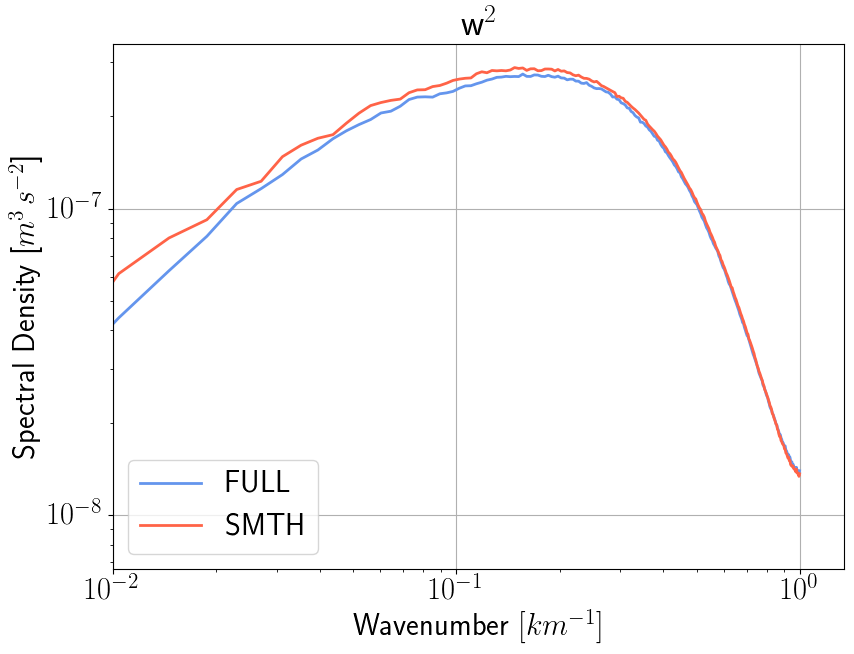

In [34]:

plt.figure(figsize=(9,7))


plt.plot(Wf.freq_r/dxx,Wf.mean(axis=0)/dxx*1e3,label='FULL',linewidth=2,color='cornflowerblue') #correcting for m in kr
plt.plot(Wt.freq_r/dxx,Wt.mean(axis=0)/dxx*1e3,label='SMTH',linewidth=2,color='tomato')

plt.legend()

plt.yscale('log')
plt.xscale('log')

plt.title(r'w$^{2}$',fontweight='bold')
plt.ylabel(r'Spectral Density [$m^3\,s^{-2}$]',fontweight='bold')
plt.xlabel(r'Wavenumber  $[km^{-1}]$',fontweight='bold')


plt.xlim(1/100,0)
# plt.ylim(1e-8,1e-1)
plt.grid()

plt.tight_layout()


plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/CROCO_surface/total_avg/Total_avg_SURFACE_w.png')

# Calculating KE

In [35]:
%time
uf=varf.u.groupby("time_counter.dayofyear").mean()
uf=uf.chunk(chunks=chunks_new);
# u_f=(uf[:,1:,:]+uf[:,:-1,:])/2
uf=uf.compute();

ut=vart.u.groupby("time_counter.dayofyear").mean()
ut=ut.chunk(chunks=chunks_new);
# ut=(ut[:,1:,:]+ut[:,:-1,:])/2
ut=ut.compute();

vf=varf.v.groupby("time_counter.dayofyear").mean()
vf=vf.chunk(chunks=chunks_new);
# vf=(vf[:,:,1:]+vf[:,:,:-1])/2
vf=vf.compute();

vt=vart.v.groupby("time_counter.dayofyear").mean()
vt=vt.chunk(chunks=chunks_new);
# vt=(vt[:,:,1:]+vt[:,:,:-1])/2
vt=vt.compute();



CPU times: user 1e+03 ns, sys: 4 µs, total: 5 µs
Wall time: 9.06 µs


In [36]:
uf,vf,_=romspickle.uvw2rho_3d(uf,vf,uf)
uf,vf=uf[:,120:-120,120:800],vf[:,120:-120,120:800]

ut,vt,_=romspickle.uvw2rho_3d(ut,vt,ut)
ut,vt=ut[:,120:-120,120:800],vt[:,120:-120,120:800]

In [37]:
with ProgressBar():
    Uf=xrft.isotropic_power_spectrum(uf,dim=['x_u','y_u'],nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor)
    Vf=xrft.isotropic_power_spectrum(vf,dim=['x_v','y_v'],nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor)
    Ut=xrft.isotropic_power_spectrum(ut,dim=['x_u','y_u'],nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor)
    Vt=xrft.isotropic_power_spectrum(vt,dim=['x_v','y_v'],nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor)

In [38]:
Ekef=xr.DataArray(data=0.5*(Uf.data + Vf.data),coords=({'dayofyear':Uf.dayofyear,'freq_r':Uf.freq_r.data}))
Eket=xr.DataArray(data=0.5*(Ut.data + Vt.data),coords=({'dayofyear':Uf.dayofyear,'freq_r':Uf.freq_r.data}))

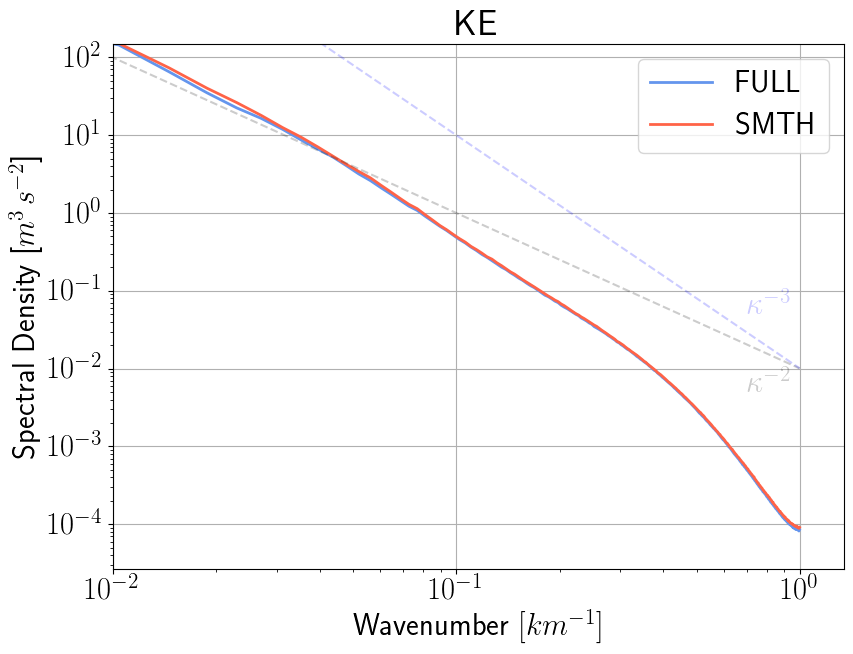

In [39]:
plt.figure(figsize=(9,7))


plt.plot(Ekef.freq_r/dxx,Ekef.mean(axis=0)*(dxx*1e3),label='FULL',linewidth=2,color='cornflowerblue')
plt.plot(Eket.freq_r/dxx,Eket.mean(axis=0)*(dxx*1e3),label='SMTH',linewidth=2,color='tomato')

k2 = np.array([Ekef.freq_r[0],Ekef.freq_r[-1]])/dxx
E2 = ((1/k2)**2)*(1e-2)

k3 = np.array([Ekef.freq_r[0],Ekef.freq_r[-1]])/dxx
E3 = ((1/k3)**3)*(1e-2)


plt.plot(k2,E2,'k--',alpha=0.2)
plt.text(0.7,0.5e-2,r'$\kappa^{-2}$',weight='normal',alpha=0.2)

plt.plot(k3,E3,'b--',alpha=0.2)
plt.text(0.7,5e-2,r'$\kappa^{-3}$',weight='normal',color='b',alpha=0.2)

plt.grid()


plt.yscale('log')
plt.xscale('log')
plt.legend()

plt.title('KE',fontweight='bold')
plt.ylabel(r'Spectral Density [$m^3\,s^{-2}$]',fontweight='bold')
plt.xlabel(r'Wavenumber  $[km^{-1}]$',fontweight='bold')

plt.xlim(1e-2,0)
plt.ylim(0,150)
plt.tight_layout()

plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/CROCO_surface/total_avg/Total_avg_SURFACE_KE.png')

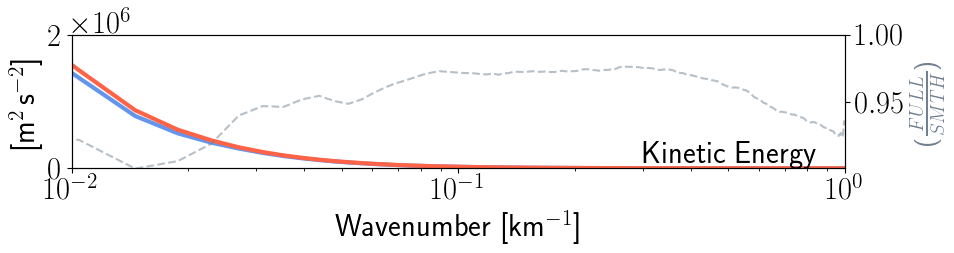

In [77]:
'Ogive graph'

# Kx,KAf=spec_ogive(spec=np.nanmean(Ekef,axis=0)/dxx*1e3,kr=Ekef.freq_r/dxx)
# _,KAt=spec_ogive(spec=np.nanmean(Eket,axis=0)/dxx*1e3,kr=Eket.freq_r/dxx)

KAf=ogive(Ekef.freq_r/dxx*1e3,np.nanmean(Ekef,axis=0)/dxx*1e3) #in metersss
Kx=Ekef.freq_r/dxx #in Kilometers
KAt=ogive(Eket.freq_r/dxx*1e3,np.nanmean(Eket,axis=0)/dxx*1e3)#in metersss






fig,ax = plt.subplots(figsize=(10,3))
ax.plot((Kx),KAf,label='FULL',linewidth=3,color='cornflowerblue')
ax.plot((Kx),KAt,label='SMTH',linewidth=3,color='tomato')
# ax.set_title('KE (Ogive)',fontsize=15,fontweight='bold')


ax.set_xscale('log')

ax.text(3e-1,0.1e6,'Kinetic Energy')



# ax.set_xticks(np.array([-2,-1]))
# ax.set_xticklabels([r'10$^{-2}$',r'10$^{-1}$'])


ax.set_xlabel(r'Wavenumber [km$^{-1}$]',fontweight='bold')
ax.set_ylabel(r'[m$^2\,$s$^{-2}$]',fontweight='bold')
# ax.set_title(r'KE',fontsize=25)
ax.set_xlim(1e-2,1)
ax.set_ylim(-0.1,2e6)



# ax.legend()

ax2=ax.twinx()
# ax2.plot((Kx),((KAf)/(KAt)-1)*100,alpha=0.5,linestyle='dashed',color='cadetblue')
ax2.plot((Kx),((KAf)/(KAt)),alpha=0.5,linestyle='dashed',color='slategrey')
ax2.set_ylim(0.901,1)



ax2.set_ylabel(r'($\frac{FULL}{SMTH}$)',fontweight='bold',fontsize=20,color='slategrey')
ax2.set_xscale('log')
plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/CROCO_surface/ogives/Ogive_avg_KE.png')

### Monthly Averages

In [44]:
# 

#fig, axs = plt.subplots(4,2, figsize=(15, 13.5), facecolor='w', edgecolor='k')
# fig.subplots_adjust(hspace = 1, wspace=.01)

# axs = axs.ravel()

# for ipp in range(len(mes)):

#     axs[ipp].plot((Ekef.freq_r/dxx),(np.nanmean(Ekef[mon_ind==mes[ipp],:],axis=0)),label='FULL',linewidth=2,color='navy')
#     axs[ipp].plot((Eket.freq_r/dxx),(np.nanmean(Eket[mon_ind==mes[ipp],:],axis=0)),label='SMTH',linewidth=2,color='lightcoral')
#     # axs[ipp].plot((k3),(E3),'k--',alpha=0.4)
#     # axs[0].text(-1.5,-2.5,r'$\kappa^{-3}$',alpha=0.1,weight='light')
#     # axs[ipp].grid()
#     axs[ipp].set_xscale('log')
#     axs[ipp].set_yscale('log')



#     axs[ipp].set_title(mes_str[ipp])
#     # axs[ipp].set_xticks(np.array([-2,-1]))
#     # axs[ipp].set_xticklabels([r'10$^{-2}$',r'10$^{-1}$'])
#     # axs[ipp].set_yticks(np.array([-5,-3,-1,1,3]))
#     # axs[ipp].set_yticklabels([r'10$^{-5}$',r'10$^{-3}$',r'10$^{-1}$',r'10$^{1}$',r'10$^{3}$'])
#     if ipp in [0,2,4,6]:
#         axs[ipp].set_ylabel(r'$E(k)$',color="k",fontsize=18,fontweight='bold')
#     if ipp in [6,7]:
#         axs[ipp].set_xlabel(r'Wavenumber $ [km^{-1}]$',fontsize=18,fontweight='bold')

#     axs[0].legend()


#     axs[ipp].set_xlim(1e-2,0)
#     # axs[ipp].set_ylim(-6,-1)


# plt.tight_layout()
# plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/CROCO_surface/monthly_KE.png')

## Windwork

In [41]:
#loading stress
usf=varf.sustr.groupby("time_counter.dayofyear").mean()
usf=usf.chunk(chunks=chunks_new);
# usf=usf[:,300:-300,90:700].compute();
usf=usf.compute();



ust=vart.sustr.groupby("time_counter.dayofyear").mean()
ust=ust.chunk(chunks=chunks_new);
ust=ust.compute();
# ust=ust[:,300:-300,90:700].compute();



vsf=varf.svstr.groupby("time_counter.dayofyear").mean()
vsf=vsf.chunk(chunks=chunks_new);
vsf=vsf.compute();
# vsf=vsf[:,300:-300,90:700].compute();


vst=vart.svstr.groupby("time_counter.dayofyear").mean()
vst=vst.chunk(chunks=chunks_new);
# vst=vst[:,300:-300,90:700].compute();
vst=vst.compute();



In [42]:
usf,vsf,_=romspickle.uvw2rho_3d(usf,vsf,usf)
ust,vst,_=romspickle.uvw2rho_3d(ust,vst,vst)

usf,vsf=usf[:,120:-120,120:800],vsf[:,120:-120,120:800]
ust,vst=ust[:,120:-120,120:800],vst[:,120:-120,120:800]

In [43]:
    # Xf=xrft.isotropic_cross_spectrum(usf,uf,
    #                                  dim=['x_u','y_u'],nfactor=2,truncate='True',detrend='linear', window=True)

In [44]:
nfw=2
with ProgressBar():
    Xf=xrft.isotropic_cross_spectrum(usf,uf,
                                      dim=['y_u','x_u'],nfactor=nfw,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor).real

    Yf=xrft.isotropic_cross_spectrum(vsf,vf,
                                      dim=['y_v','x_v'],nfactor=nfw,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor).real


    Xt=xrft.isotropic_cross_spectrum(ust,ut,
                                      dim=['y_u','x_u'],nfactor=nfw,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor).real

    Yt=xrft.isotropic_cross_spectrum(vst,vt,
                                      dim=['y_v','x_v'],nfactor=nfw,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor).real



In [45]:

WWf=xr.DataArray(data=(1/1024)*(Xf.real.data + Yf.real.data),coords=({'dayofyear':Xf.dayofyear,'freq_r':Xf.freq_r.data}));
WWt=xr.DataArray(data=(1/1024)*(Xt.real.data + Yt.real.data),coords=({'dayofyear':Xf.dayofyear,'freq_r':Xf.freq_r.data}));

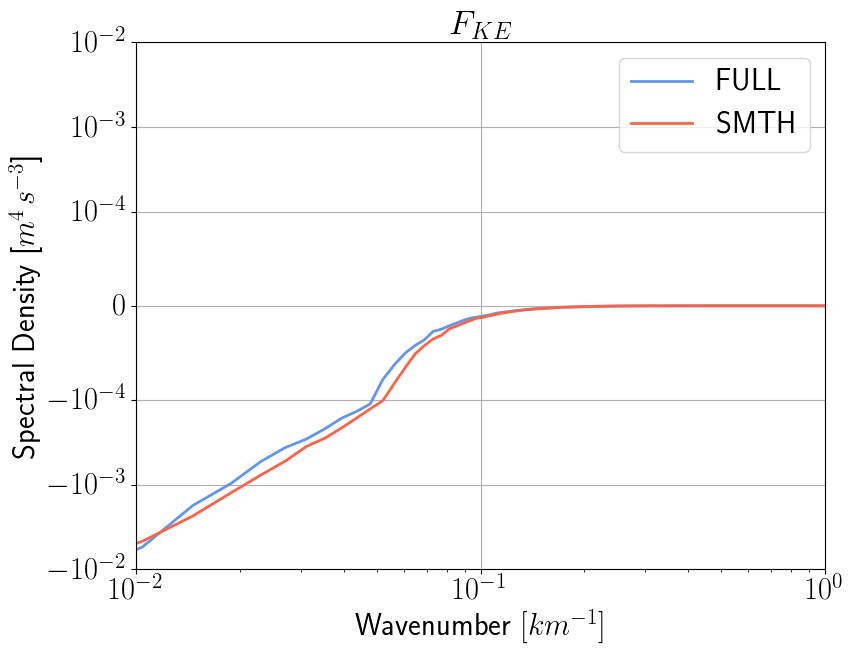

In [46]:

plt.figure(figsize=(9,7))


plt.plot((WWf.freq_r/dxx),(np.nanmean(WWf,axis=0))*(dxx*1e3),label='FULL',linewidth=2,color='cornflowerblue')
plt.plot((WWt.freq_r/dxx),(np.nanmean(WWt,axis=0))*(dxx*1e3),label='SMTH',linewidth=2,color='tomato')
# plt.plot([1/50,1/50],[1000,0],'k--')

plt.legend()

plt.xlabel(r'Wavenumber  $[km^{-1}]$',fontweight='bold')
plt.ylabel(r'Spectral Density [$m^4\,s^{-3}$]',fontweight='bold')

plt.title(r'$F_{KE}$',fontsize=25,fontweight='bold')
plt.yscale('symlog', linthresh=1e-4)
plt.xscale('log')

plt.ylim(-1e-2,1e-2)
plt.xlim(1e-2,1)
plt.grid()

plt.tight_layout()
# plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/CROCO_surface/total_avg/Total_avg_Windwork_KE.png')


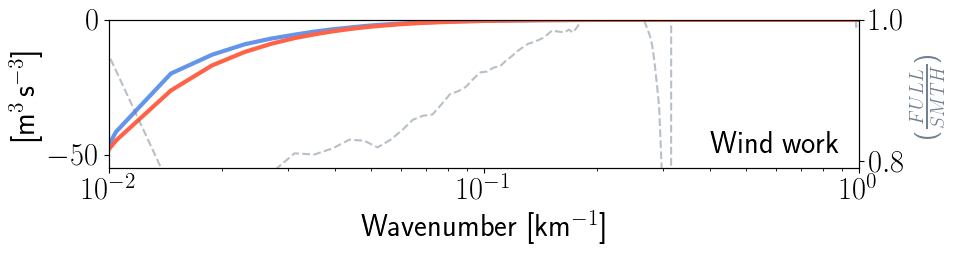

In [78]:
'Ogive'

# Kx,WWpf=spec_ogive(spec=np.nanmean(WWf,axis=0)*(dxx*1e3),kr=WWf.freq_r/dxx)
# _,WWpt=spec_ogive(spec=np.nanmean(WWt,axis=0)*(dxx*1e3),kr=WWt.freq_r/dxx)


WWpf=ogive(WWf.freq_r/dxx*1e3,np.nanmean(WWf,axis=0)/dxx*1e3) #in metersss
Kx=WWf.freq_r/dxx #in Kilometers
WWpt=ogive(WWt.freq_r/dxx*1e3,np.nanmean(WWt,axis=0)/dxx*1e3)#in metersss




fig,ax = plt.subplots(figsize=(10,3))

ax.plot(Kx,WWpf,label='FULL',linewidth=3,color='cornflowerblue')
ax.plot(Kx,WWpt,label='SMTH',linewidth=3,color='tomato')

ax.set_xlabel(r'Wavenumber  [km$^{-1}$]',fontweight='bold')
# ax.set_ylabel(r'Spectral Density [m$^3\,$s$^{-3}$]',fontweight='bold')
ax.set_ylabel(r'[m$^3\,$s$^{-3}$]',fontweight='bold')


# ax.set_title(r'$F_{KE}$',fontsize=25,fontweight='bold')
ax.text(4e-1,-49,'Wind work')

ax.set_xscale('log')

# ax.set_xticks(np.array([-2,-1]))
# ax.set_xticklabels([r'10$^{-2}$',r'10$^{-1}$'])
ax.set_ylim(-55,0.1)
ax.set_xlim(1e-2,1)
# ax.legend(loc=4)
decx=1
ax2=ax.twinx()
# ax2.plot(Kx[::decx],(np.abs(WWpf)/np.abs(WWpt))[::decx],alpha=0.5,linestyle='dashed',color='slategrey')

ax2.plot(Kx[::decx],(WWpf)/(WWpt)[::decx],alpha=0.5,linestyle='dashed',color='slategrey')


ax2.set_ylabel(r'($\frac{FULL}{SMTH}$)',fontsize=20,color='slategrey')
ax2.set_ylim(0.79,1)
ax2.set_xscale('log')
# plt.grid()

plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/CROCO_surface/ogives/Ogive_avg_Windwork.png')




# Energy Ratio

# Panel Figure

In [113]:
PeM_f=(1/(2*N2r))*Bf.mean(axis=0)
PeM_t=(1/(2*N2r))*Bt.mean(axis=0)
KeM_f=Ekef.mean(axis=0)
KeM_t=Eket.mean(axis=0)


R_f=PeM_f.data/KeM_f.data
R_t=PeM_t.data/KeM_t.data

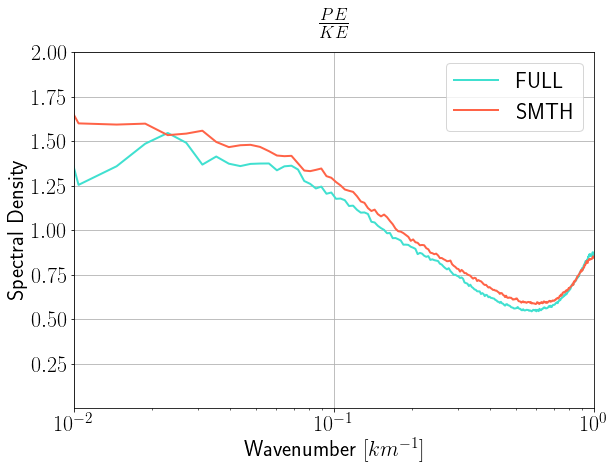

In [131]:

plt.figure(figsize=(9,7))


plt.plot((Ekef.freq_r/dxx),R_f,label='FULL',linewidth=2,color='cornflowerblue')
plt.plot((Eket.freq_r/dxx),R_t,label='SMTH',linewidth=2,color='tomato')
# plt.plot([1/50,1/50],[1000,0],'k--')

plt.legend()

plt.xlabel(r'Wavenumber  $[km^{-1}]$',fontweight='bold')
plt.ylabel(r'Spectral Density',fontweight='bold')

plt.title(r'$\frac{PE}{KE}$',fontsize=25,fontweight='bold',y=1.05)
# plt.yscale('symlog', linthresh=1e-4)
plt.xscale('log')

plt.ylim(0.001,2)
plt.xlim(1e-2,1)
plt.grid()

plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/CROCO_surface/total_avg/Ratio_PE-KE.png')



### Potential energy from Thermal

In [155]:
import seawater as sw
alpha_f2=(sw.alpha(sf,tf,p=0))**2
alpha_t2=(sw.alpha(st,tt,p=0))**2
g2=9.8**2

In [ ]:
bt_f=tf

In [ ]:

with ProgressBar():
    TTf=xrft.isotropic_power_spectrum(tf.drop(['nav_lat_rho','nav_lon_rho','dayofyear']),
                                      dim=['y_rho','x_rho'],
                              nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor)

    TTt=xrft.isotropic_power_spectrum(tt.drop(['nav_lat_rho','nav_lon_rho','dayofyear']),
                                      dim=['y_rho','x_rho'],
                              nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor)

In [156]:
PetM_f=(1/(2*N2r))*(alpha_f2[:,None]*g2*TTf).mean(axis=0)
PetM_t=(1/(2*N2r))*(alpha_t2[:,None]*g2*TTt).mean(axis=0)
KeM_f=Ekef.mean(axis=0)
KeM_t=Eket.mean(axis=0)


R_f=PetM_f.data/KeM_f.data
R_t=PetM_t.data/KeM_t.data

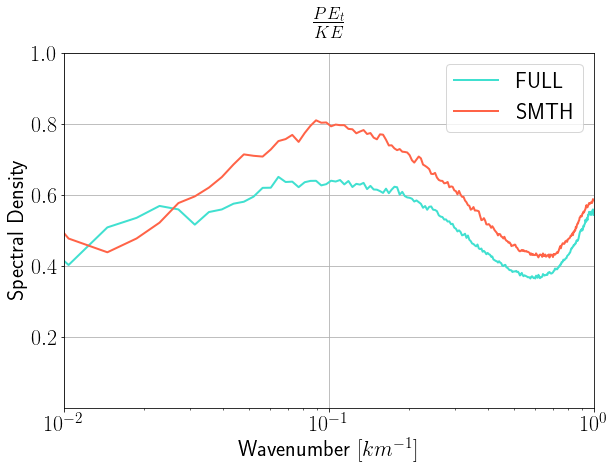

In [160]:

plt.figure(figsize=(9,7))


plt.plot((Ekef.freq_r/dxx),R_f,label='FULL',linewidth=2,color='cornflowerblue')
plt.plot((Eket.freq_r/dxx),R_t,label='SMTH',linewidth=2,color='tomato')
# plt.plot([1/50,1/50],[1000,0],'k--')

plt.legend()

plt.xlabel(r'Wavenumber  $[km^{-1}]$',fontweight='bold')
plt.ylabel(r'Spectral Density',fontweight='bold')

plt.title(r'$\frac{PE_t}{KE}$',fontsize=25,fontweight='bold',y=1.05)
# plt.yscale('symlog', linthresh=1e-4)
plt.xscale('log')

plt.ylim(0.001,1)
plt.xlim(1e-2,1)
plt.grid()

plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/CROCO_surface/total_avg/Ratio_PEt-KE.png')



## Spectral Coupling Coefficients
### WindStress x SST CoSpectra

In [221]:
chunks_new={'dayofyear':40}

In [222]:
# wstr_f=xr.DataArray(data=(np.sqrt(us_f.data**2 + vs_f.data**2)),dims=['dayofyear', 'y_rho', 'x_rho'])
# wstr_t=xr.DataArray(data=(np.sqrt(us_t.data**2 + vs_t.data**2)),dims=['dayofyear', 'y_rho', 'x_rho'])

wstr_f=xr.DataArray(data=(np.sqrt(usf.data**2 + vsf.data**2)),dims=['dayofyear', 'y_rho', 'x_rho'])
wstr_t=xr.DataArray(data=(np.sqrt(ust.data**2 + vst.data**2)),dims=['dayofyear', 'y_rho', 'x_rho'])

In [266]:

tf=varf.temp.groupby("time_counter.dayofyear").mean()
tf=tf.chunk(chunks=chunks_new);
tf=tf.compute();

tt=vart.temp.groupby("time_counter.dayofyear").mean()
tt=tt.chunk(chunks=chunks_new);
tt=tt.compute();

tf,tt=romspickle.ts2rho_3d(tf,tt)

tf=tf[:,120:-120,120:800]
tt=tt[:,120:-120,120:800]


In [269]:
with ProgressBar():
    Cf=xrft.isotropic_cross_spectrum(wstr_f,tf.drop(['nav_lat_rho', 'nav_lon_rho','dayofyear']),
                                     dim=['y_rho','x_rho'],nfactor=nfw,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor).real
    Ct=xrft.isotropic_cross_spectrum(wstr_t,tt.drop(['nav_lat_rho', 'nav_lon_rho','dayofyear']),
                                     dim=['y_rho','x_rho'],nfactor=nfw,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor).real

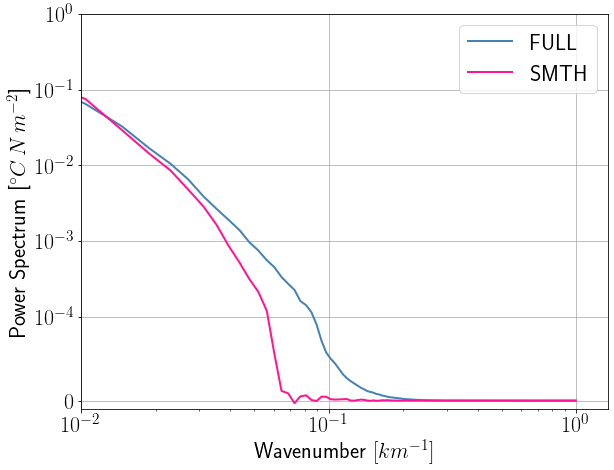

In [366]:

plt.figure(figsize=(9,7))


plt.plot((Cf.freq_r/dxx),(np.nanmean(Cf,axis=0)),label='FULL',linewidth=2,color='SteelBlue')
plt.plot((Ct.freq_r/dxx),(np.nanmean(Ct,axis=0)),label='SMTH',linewidth=2,color='DeepPink')
# plt.plot([1/50,1/50],[1000,0],'k--')


plt.legend()

plt.xlabel(r'Wavenumber  $[km^{-1}]$',fontweight='bold')
plt.ylabel(r'Power Spectrum [$^{\circ}C\,N\,m^{-2}$]',fontweight='bold')


plt.yscale('symlog',linthresh=1e-4)
plt.xscale('log')

plt.ylim(-10**(-5),10e-1)
plt.xlim(1e-2,0)
plt.grid()
plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/CROCO_surface/total_avg/Total_avg_WindStressxSST.png')
# 




## b x HFX

In [309]:
sf=varf.salt.groupby("time_counter.dayofyear").mean()
sf=sf.chunk(chunks=chunks_new);
sf=sf.compute();

st=vart.salt.groupby("time_counter.dayofyear").mean()
st=st.chunk(chunks=chunks_new);
st=st.compute();

sf,st=romspickle.ts2rho_3d(sf,st)

sf=sf[:,120:-120,120:800]
st=st[:,120:-120,120:800]


In [321]:
hf=-varf.shflx.groupby("time_counter.dayofyear").mean()
hf=hf.chunk(chunks=chunks_new);
hf=hf.compute()


ht=-vart.shflx.groupby("time_counter.dayofyear").mean()
ht=ht.chunk(chunks=chunks_new);
ht=ht.compute()

hf,ht=romspickle.ts2rho_3d(hf,ht)


hf=hf[:,120:-120,120:800];
ht=ht[:,120:-120,120:800];




In [315]:
rhof=xroms.roms_seawater.potential_density(tf,sf,z=0)
rhot=xroms.roms_seawater.potential_density(tt,st,z=0)


In [316]:
bf=xroms.roms_seawater.buoyancy(rhof)
bt=xroms.roms_seawater.buoyancy(rhot)

In [344]:
nf=2
wdws=True #'flattop','hann'
wdw_cor=None
scl='density'

with ProgressBar():
    Gf=xrft.isotropic_cross_spectrum(bf.drop(['nav_lat_rho', 'nav_lon_rho']),hf.drop(['nav_lat_rho', 'nav_lon_rho']),
                                     dim=['x_rho','y_rho'],nfactor=nfw,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor).real
    Gt=xrft.isotropic_cross_spectrum(bt.drop(['nav_lat_rho', 'nav_lon_rho']),ht.drop(['nav_lat_rho', 'nav_lon_rho']),
                                     dim=['x_rho','y_rho'],nfactor=nfw,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor).real

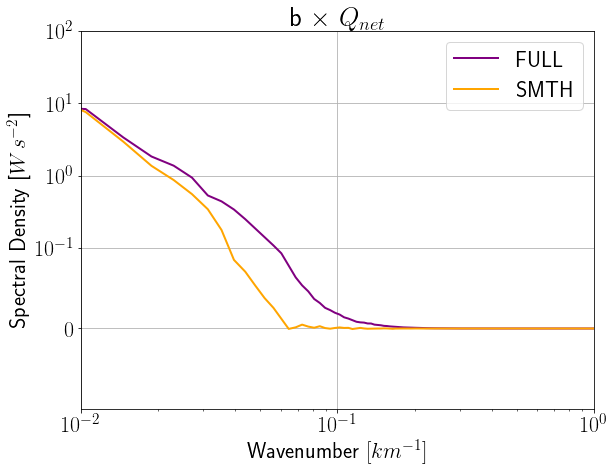

In [369]:

plt.figure(figsize=(9,7))


plt.plot((Gf.freq_r/dxx),np.nanmean(Gf,axis=0)*(dxx*1e3),label='FULL',linewidth=2,color='purple')
plt.plot((Gt.freq_r/dxx),np.nanmean(Gt,axis=0)*(dxx*1e3),label='SMTH',linewidth=2,color='orange')
# plt.plot([1/50,1/50],[1000,0],'k--')


plt.legend()


plt.xlabel(r'Wavenumber  $[km^{-1}]$',fontweight='bold')
plt.ylabel(r'Spectral Density [$W\,s^{-2}$] ',fontweight='bold')
plt.title(r'b $\times$ $Q_{net}$',fontweight='bold')
# plt.yscale('symlog',linthresh=1e-5)
plt.yscale('symlog',linthresh=1e-1)


plt.xscale('log')

plt.ylim(-1e-1,1e2)
plt.xlim(1e-2,1)
plt.grid()

plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/CROCO_surface/total_avg/Total_avg_bxHFX.png')




## Ogive graphs

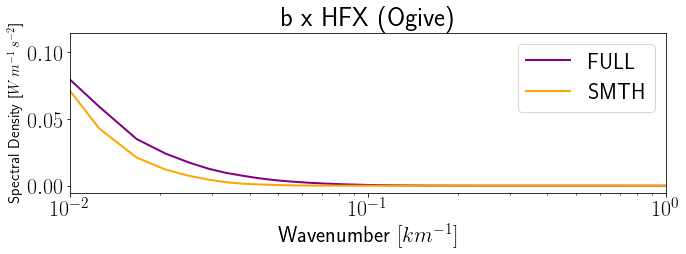

In [368]:


Kx,GGpf=spec_ogive(spec=np.nanmean(Gf,axis=0)*(dxx*1e3),kr=Gf.freq_r/dxx)
_,GGpt=spec_ogive(spec=np.nanmean(Gt,axis=0)*(dxx*1e3),kr=Gt.freq_r/dxx)




# ggf=np.nanmean(Gf,axis=0)
# ggt=np.nanmean(Gt,axis=0)

# Kk=np.array(Gf.freq_r/dxx)
# Kx=(Kk[:-1]+Kk[1:])/2
# dK=np.diff(Kk)[0]


# GGpf=integ.cumtrapz(y=ggf[::-1],x=Kk[::-1]);
# GGpt=integ.cumtrapz(y=ggt[::-1],x=Kk[::-1]);
# GGpf=-GGpf[::-1]
# GGpt=-GGpt[::-1]



fig,ax = plt.subplots(figsize=(10,4))
ax.plot(Kx,GGpf,label='FULL',linewidth=2,color='purple')
ax.plot(Kx,GGpt,label='SMTH',linewidth=2,color='orange')
ax.set_xlabel(r'Wavenumber  $[km^{-1}]$',fontweight='bold')
ax.set_ylabel(r'Spectral Density [$ W\,m^{-1}\,s^{-2}$]',fontweight='bold',fontsize=15)
ax.set_title(r'b x HFX (Ogive)',fontweight='bold')

ax.set_xscale('log')

# ax.set_xticks(np.array([-2,-1]))
# ax.set_xticklabels([r'10$^{-2}$',r'10$^{-1}$'])
# ax.set_ylim(0.0001,0.6)
ax.set_xlim(1e-2,1)
ax.legend()

# ax2=ax.twinx()
# ax2.plot(Kx,(((GGpf)/(GGpt)-1))*100,alpha=0.5,linestyle='dashed',color='cadetblue')
# ax2.set_ylabel(r'($\frac{FULL}{SMTH}-1)\times 100$  [$\%$]',fontsize=15,color='cadetblue')
# ax2.set_xscale('log')
# # ax2.set_ylim(-25,25)

plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/CROCO_surface/ogives/Ogive_avg_bxHFX.png')




## Coefficient HFX/SST or "$\alpha$"

In [347]:
nf=2
wdws=True #'flattop','hann'
wdw_cor=None
scl='density'

with ProgressBar():
    TTf=xrft.isotropic_power_spectrum(tf.drop(['nav_lat_rho','nav_lon_rho','dayofyear']),
                                      dim=['y_rho','x_rho'],
                              nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor)

    TTt=xrft.isotropic_power_spectrum(tt.drop(['nav_lat_rho','nav_lon_rho','dayofyear']),
                                      dim=['y_rho','x_rho'],
                              nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor)

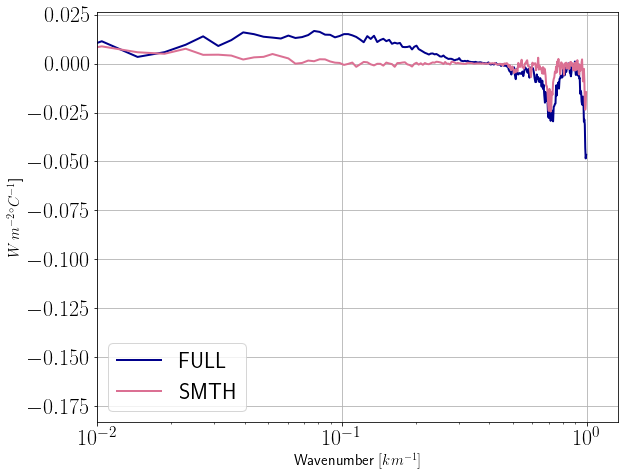

In [349]:
plt.figure(figsize=(9,7))


plt.plot((Gf.freq_r/dxx),np.nanmean((Gf.data/TTf.data),axis=0),label='FULL',linewidth=2,color='DarkBlue')
plt.plot((Gt.freq_r/dxx),np.nanmean((Gt.data/TTt.data),axis=0),label='SMTH',linewidth=2,color='PaleVioletRed')

plt.legend()


plt.xlabel(r'Wavenumber  $[km^{-1}]$',fontweight='bold',fontsize=15)
plt.ylabel(r'$ W\,m^{-2}$$^{\circ}C^{-1}$] ',fontweight='bold',fontsize=15)

# plt.yscale('symlog',linthresh=1e-5)
# plt.yscale('symog',linthresh=1e-3)

# plt.yscale('log')
plt.xscale('log')

# plt.ylim(-20,20)
plt.xlim(1e-2,0)
plt.grid()

plt.tight_layout()
# plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/CROCO_surface/total_avg/Total_avg_SSTxshflx.png')

